# Testing DeepER

### Import libraries

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import sys
sys.path.append('../..')

In [4]:
import time
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
from deeper_model import build_model
from deeper_utils import preprocess_data
from custom_callbacks import Metrics

### Read the dataset

In [7]:
!ls ../..

CameraDatasetParser.ipynb		   deeper_model.py  __pycache__
createfaketrainingsamples_fodorszagats.py  deeper_utils.py  README.md
custom_callbacks.py			   glove	    training.py
datasets				   lsh-test-data
deeperenv				   notebooks


In [9]:
trainData, testData, valData, embeddingMatrix, wordsWithNoEmbeddings = preprocess_data(
    'DI2KG', baseDir = '../..', usePretrainedModel=False,embeddingFilename='glove.840B.300d.txt',embeddingDir='glove',
    datasetDir='datasets', maxSequenceLength=100)

Printing out words with no embeddings in GloVe

In [10]:
PRINT_RANGE = 30

if len(wordsWithNoEmbeddings) < PRINT_RANGE:
    PRINT_RANGE = len(wordsWithNoEmbeddings)

if PRINT_RANGE > 0:   
    for i in range(PRINT_RANGE):
        print(wordsWithNoEmbeddings[i])

print('...')
print("There are {} words with no embeddings in GloVe".format(len(wordsWithNoEmbeddings)))

wb350f
coolplix
w830
sx160
xq1
dmcsz8k
150is
850ihs
hxa500h
xp70
dschx60vb
priceme
s6800
s9200
d5200
gc110
sx510
itwist
f124
l28
hx30v
wb2200f
s4300
620uz
l05
s4500
t550
hs20exr
x020
d750
...
There are 152 words with no embeddings in GloVe


Print embedding matrix shape

In [11]:
embeddingMatrix.shape

(672, 300)

In [12]:
leftTableTrainData, rightTableTrainData, trainLabels = trainData
leftTableTestData, rightTableTestData, testLabels = testData
leftTableValData, rightTableValData, valLabels = valData

Print training set size

In [16]:
print(leftTableTrainData.shape)
print(rightTableTrainData.shape)

(4195, 100)
(4195, 100)


Print test set size

In [17]:
print(leftTableTestData.shape)
print(rightTableTestData.shape)

(524, 100)
(524, 100)


Print validation set size

In [10]:
print(leftTableValData.shape)
print(rightTableValData.shape)

(525, 100)
(525, 100)


### Build the DeepER model 

In [14]:
model = build_model(embeddingMatrix, lstmUnits=75, denseUnits=[16, 8], lstm_dropout=0.1, mask_zero=True, maxSequenceLength=100)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     201600      input_1[0][0]                    
                                                                 input_2[0][0]                    
_____________________

### Plot DeepER architecture

In [15]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

### Training

In [18]:
start_time = time.time()

metricsHistory = Metrics()
history = model.fit([leftTableTrainData,
           rightTableTrainData],
          trainLabels,
          batch_size=16,
          epochs=20,
          callbacks=[metricsHistory],
          validation_data=([leftTableValData,
                            rightTableValData],
                           valLabels))

elapsed_time = time.time() - start_time
t = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print('Elapsed time (learning):', t)

Instructions for updating:
Use tf.cast instead.
Train on 4195 samples, validate on 525 samples
Epoch 1/20
4195/4195 [==============================] - 184s 44ms/step - loss: 0.0198 - acc: 0.9905 - val_loss: 0.0104 - val_acc: 0.9981
Updating best model
Current best model comes from epoch 0
val_f1:0.98	val_precision: 1.0	val_recall: 0.96

Epoch 2/20
4195/4195 [==============================] - 180s 43ms/step - loss: 0.0025 - acc: 0.9995 - val_loss: 4.1698e-04 - val_acc: 1.0000
Updating best model
Current best model comes from epoch 1
val_f1:1.0	val_precision: 1.0	val_recall: 1.0

Epoch 3/20
4195/4195 [==============================] - 180s 43ms/step - loss: 7.3312e-05 - acc: 1.0000 - val_loss: 1.1658e-05 - val_acc: 1.0000
val_f1:1.0	val_precision: 1.0	val_recall: 1.0

Epoch 4/20
4195/4195 [==============================] - 180s 43ms/step - loss: 8.3986e-06 - acc: 1.0000 - val_loss: 6.3722e-06 - val_acc: 1.0000
val_f1:1.0	val_precision: 1.0	val_recall: 1.0

Epoch 5/20
4195/4195 [=========

### Plot loss

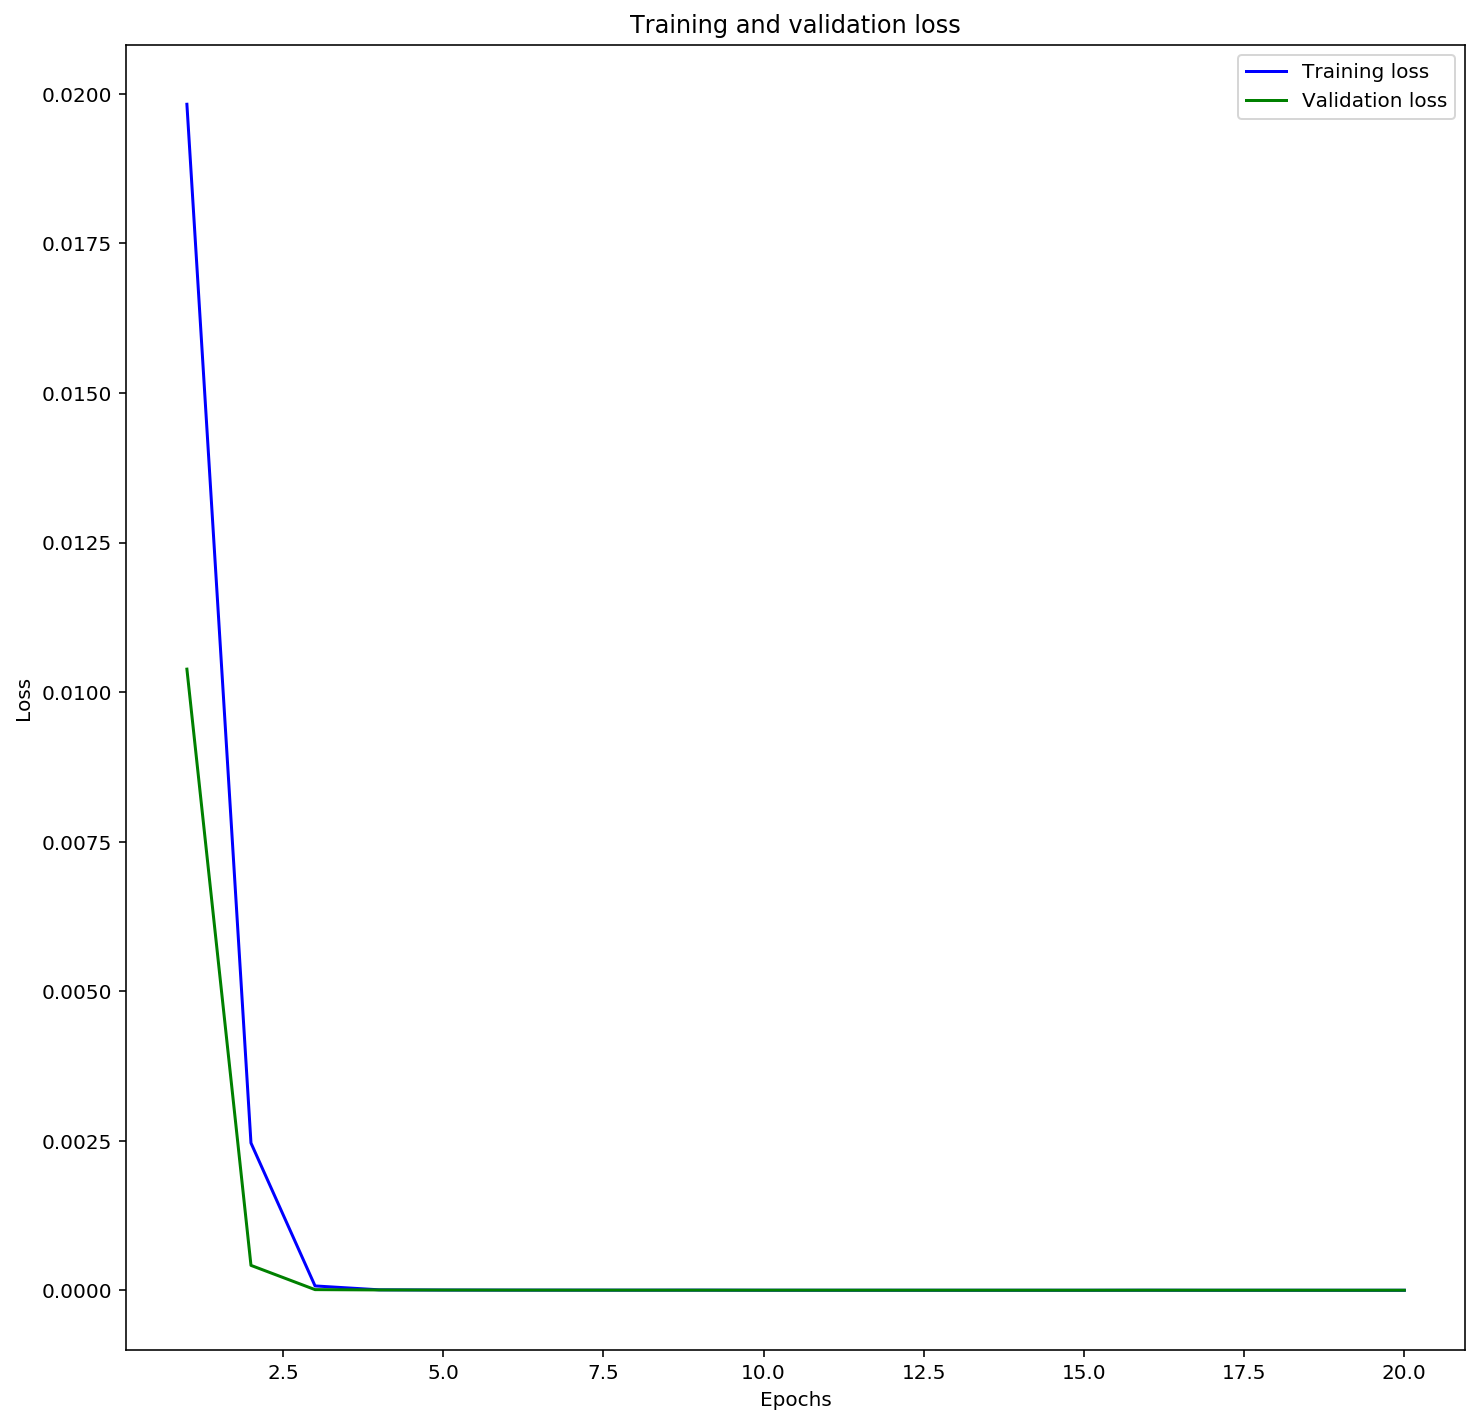

In [19]:
history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,12))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### Plot accuracy

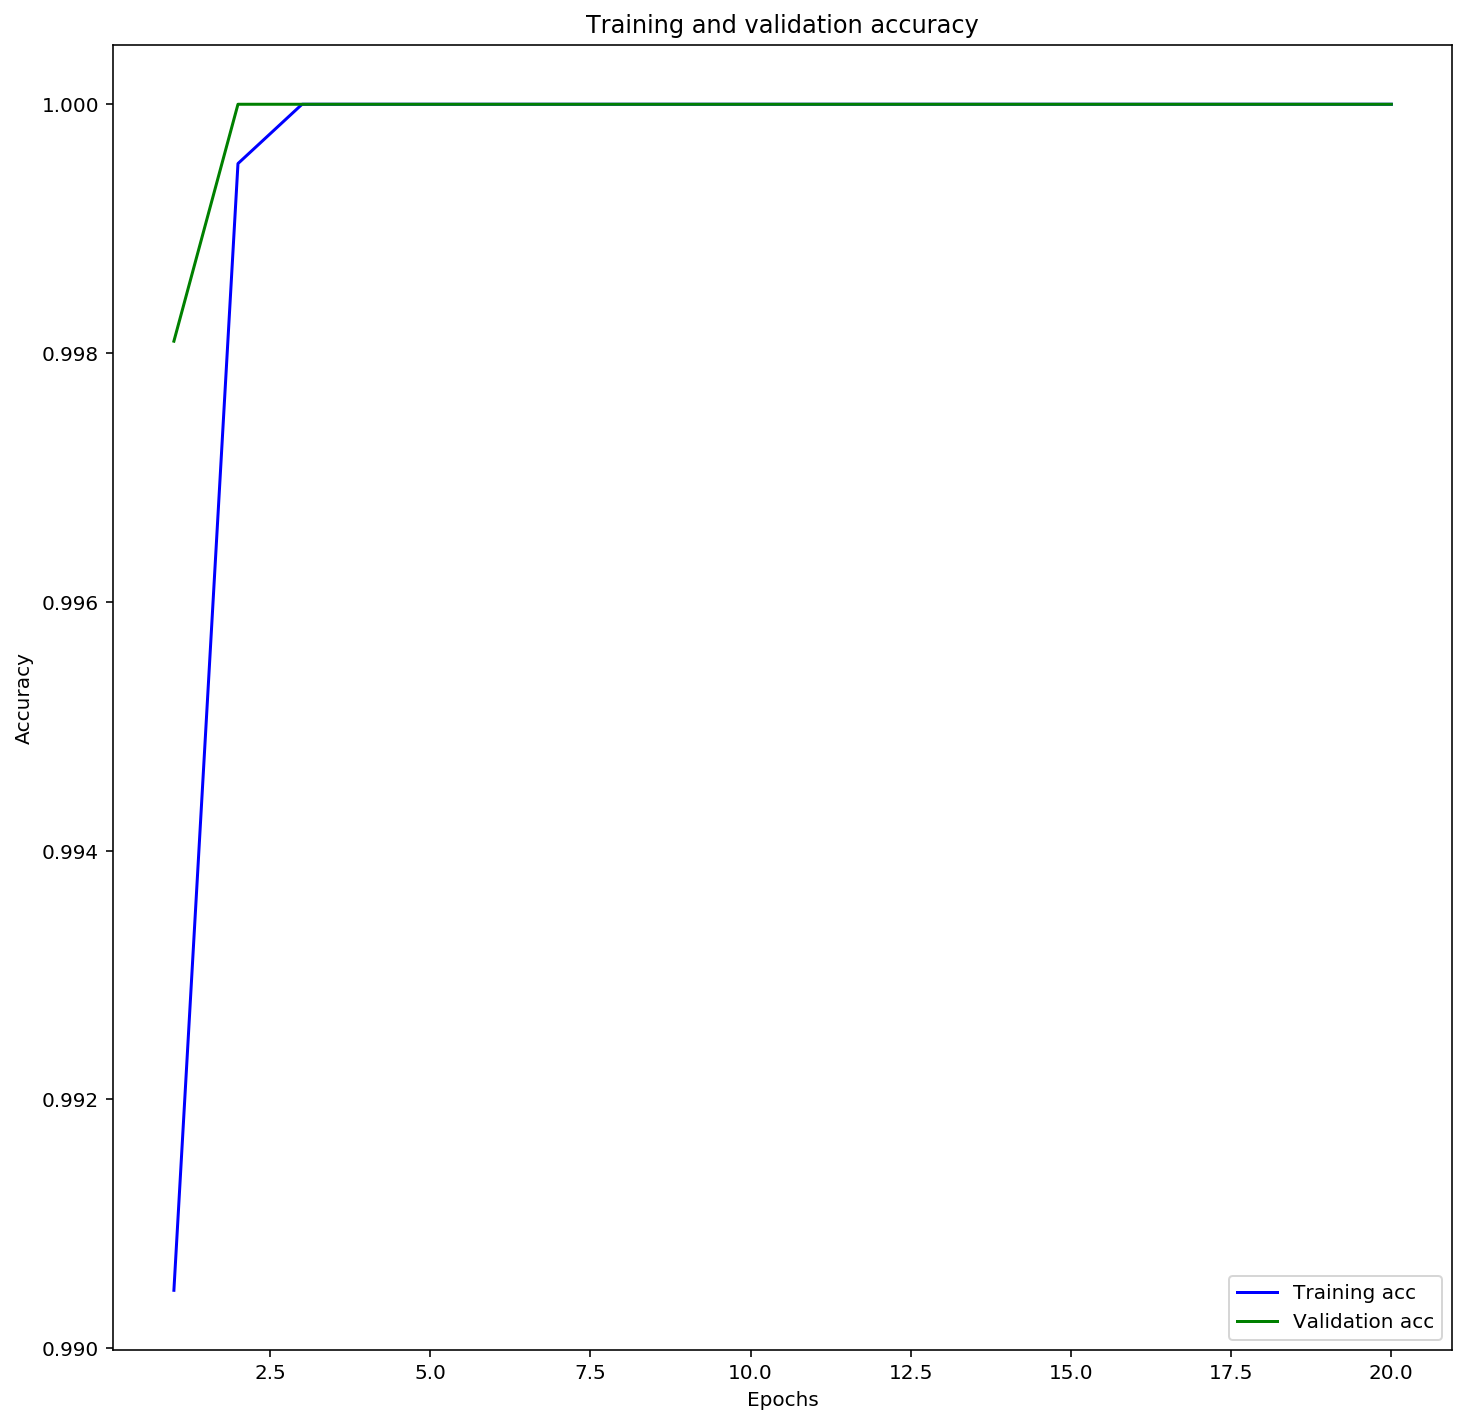

In [20]:
plt.figure(figsize=(12,12))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

### Plot precision (for matching records)

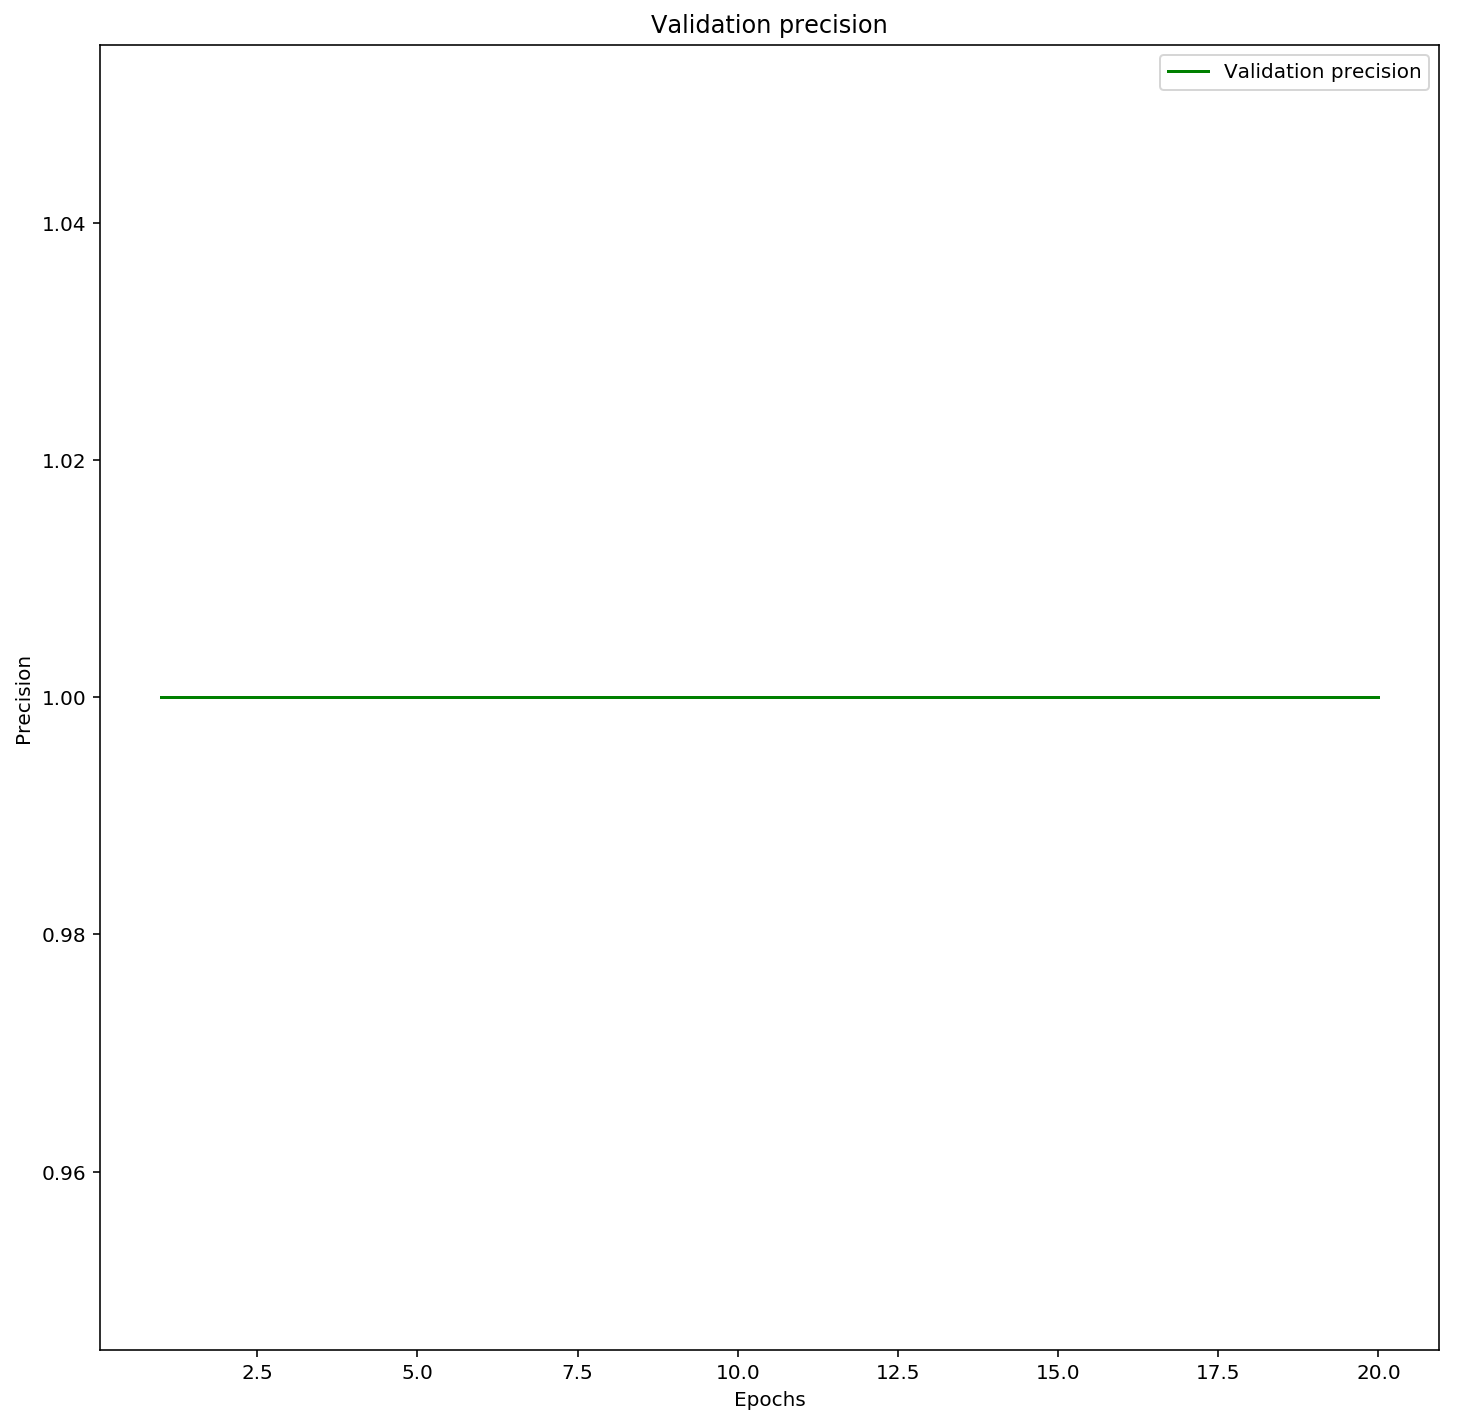

In [16]:
plt.figure(figsize=(12,12))
valPrecision = metricsHistory.valPrecisionHistory
plt.plot(epochs, valPrecision, 'g', label='Validation precision')
plt.title('Validation precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

### Plot recall (for matching records)

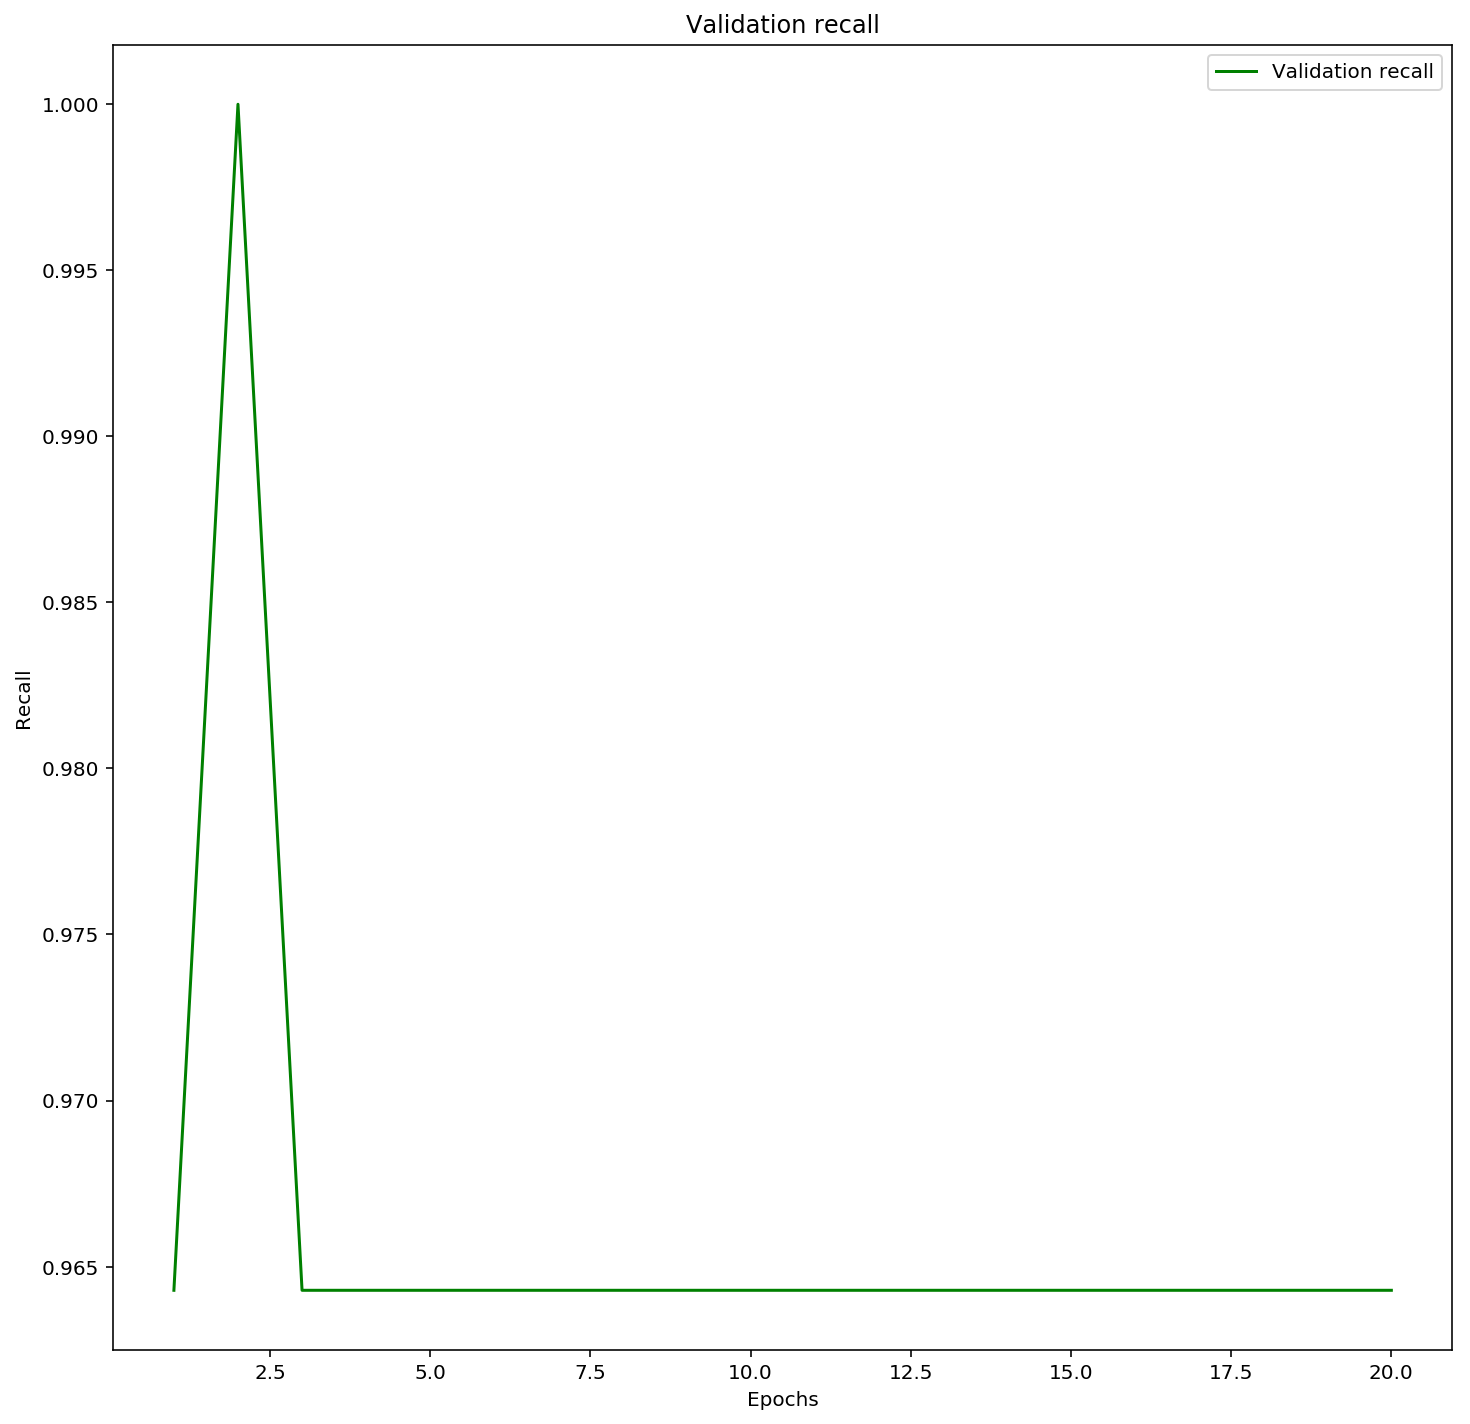

In [17]:
plt.figure(figsize=(12,12))
valRecall = metricsHistory.valRecallHistory
plt.plot(epochs, valRecall, 'g', label='Validation recall')
plt.title('Validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

### Plot F-measure (for matching records)

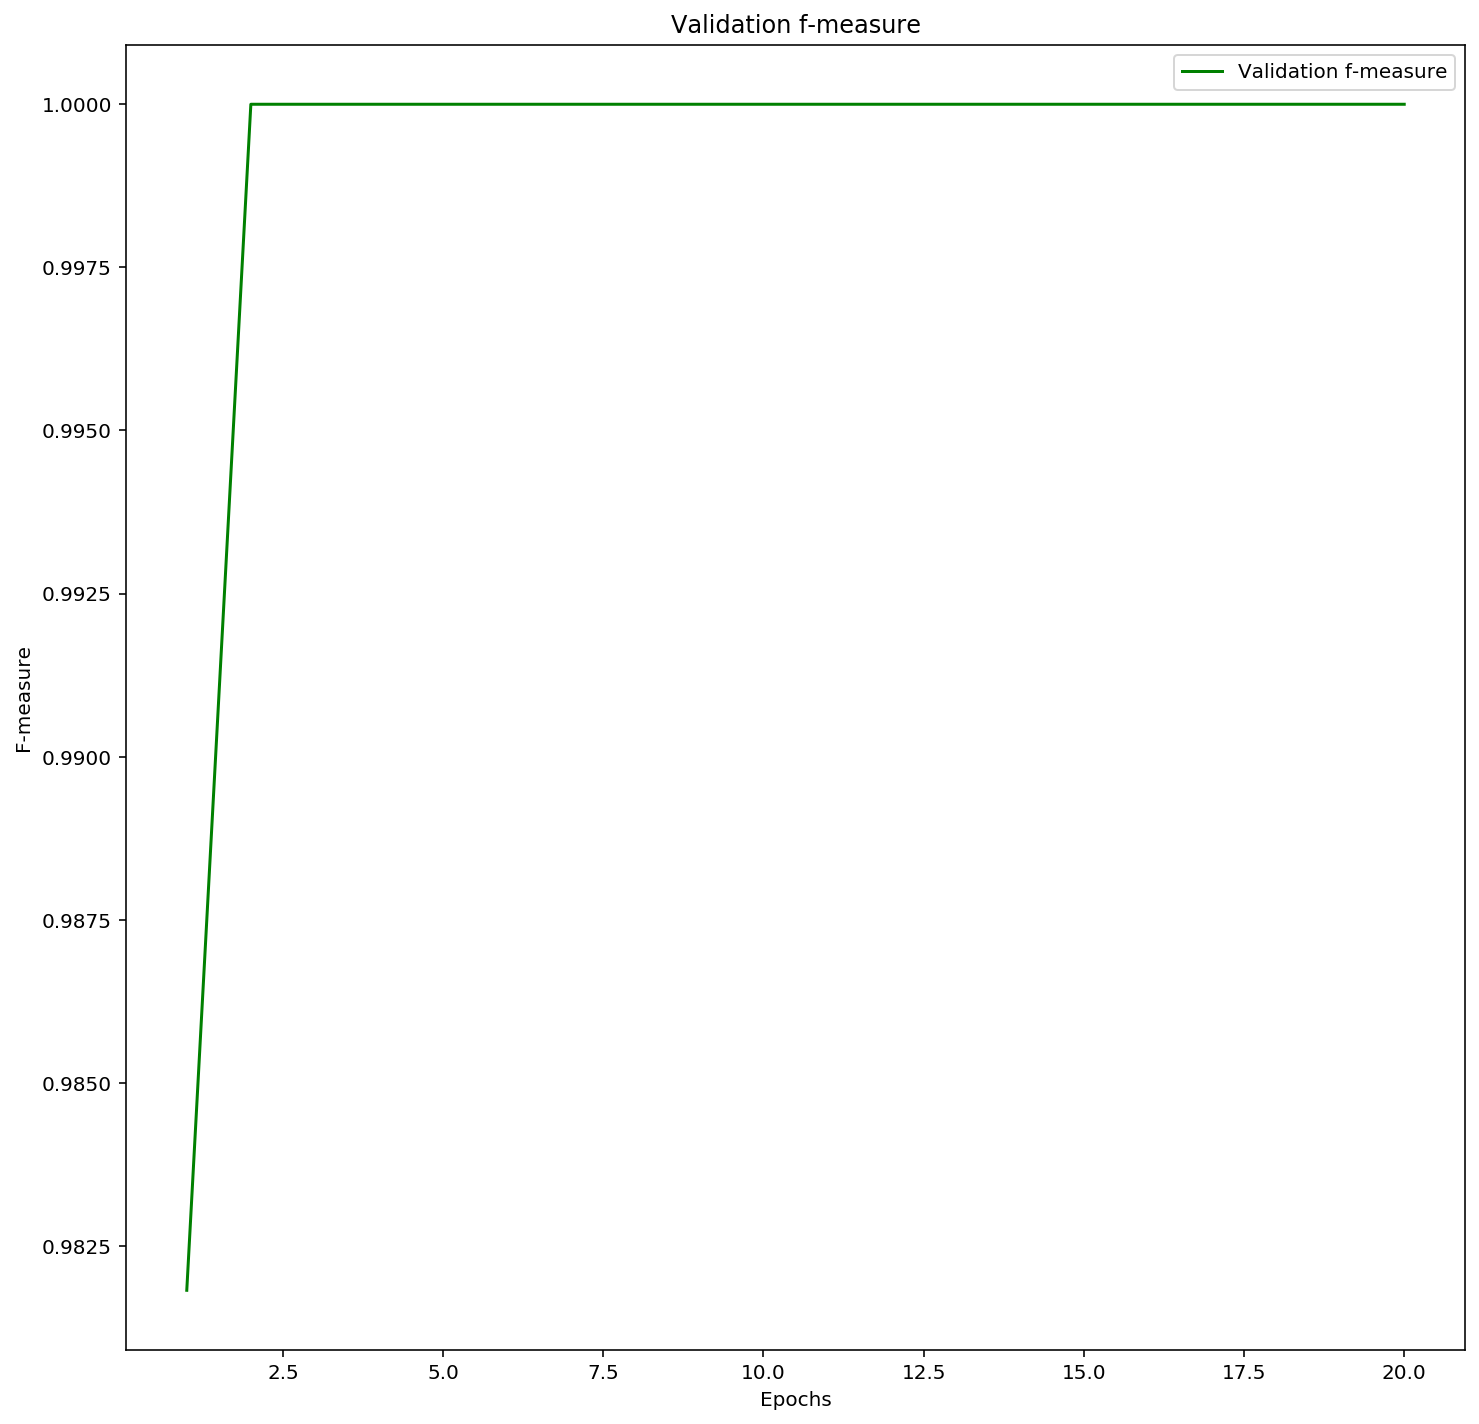

In [21]:
plt.figure(figsize=(12,12))
valFMeasure = metricsHistory.valFMeasureHistory
plt.plot(epochs, valFMeasure, 'g', label='Validation f-measure')
plt.title('Validation f-measure')
plt.xlabel('Epochs')
plt.ylabel('F-measure')
plt.legend()

### Evaluating the model trained on 20 epoch

### Predict labels on test data 

In [22]:
model.save('camera_model_20epochs.h5')

In [24]:
predictedLabels = model.predict(x=[leftTableTestData, rightTableTestData])
predictedBinaryLabels = predictedLabels.argmax(axis=1)
testBinaryLabels = testLabels.argmax(axis=1)

### Compute confusion matrix

[Text(0, 0.5, 'non matching'), Text(0, 1.5, 'matching')]

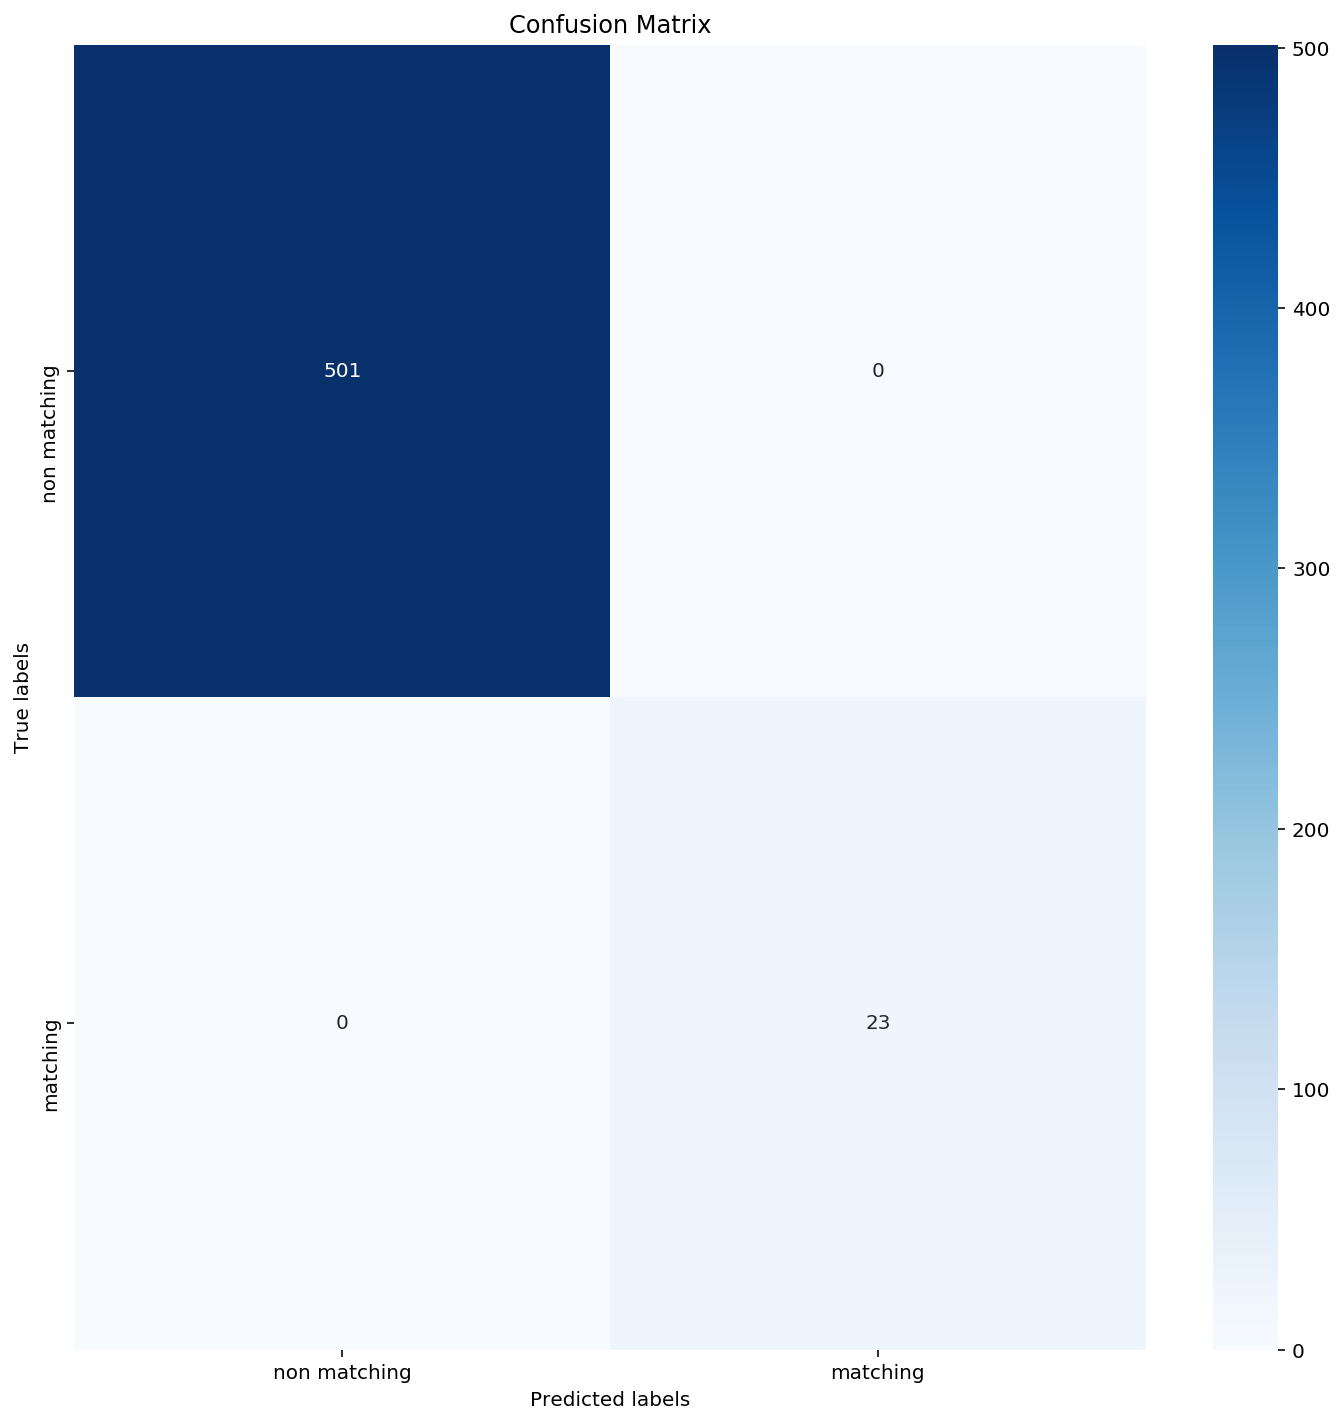

In [20]:
cm = confusion_matrix(testBinaryLabels, predictedBinaryLabels)
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['non matching', 'matching'])
ax.yaxis.set_ticklabels(['non matching', 'matching'])

### Compute metrics

In [25]:
precisionValues, recallValues, fMeasureValues, supportValues = precision_recall_fscore_support(testBinaryLabels, predictedBinaryLabels)

NUM_LABELS = len(precisionValues)

row_format ="{:>15}" * 5
print(row_format.format('Label','Precision', 'Recall', 'F-measure', 'Support'))

for i in range(NUM_LABELS):
    fMeasure = fMeasureValues[i]
    
    if fMeasure is None:
        fMeasure = 0.0
        
    print(row_format.format(i, round(precisionValues[i], 2), round(recallValues[i], 2), round(fMeasureValues[i],2), round(supportValues[i],2)))

          Label      Precision         Recall      F-measure        Support
              0            1.0            1.0            1.0            501
              1            1.0            1.0            1.0             23


---

### Evaluating the "best" model

### Loading the model

In [26]:
bestModel = load_model('best-model.h5')

### Predict labels on test data 

In [27]:
predictedLabels = bestModel.predict(x=[leftTableTestData, rightTableTestData])
predictedBinaryLabels = predictedLabels.argmax(axis=1)

### Compute confusion matrix

[Text(0, 0.5, 'non matching'), Text(0, 1.5, 'matching')]

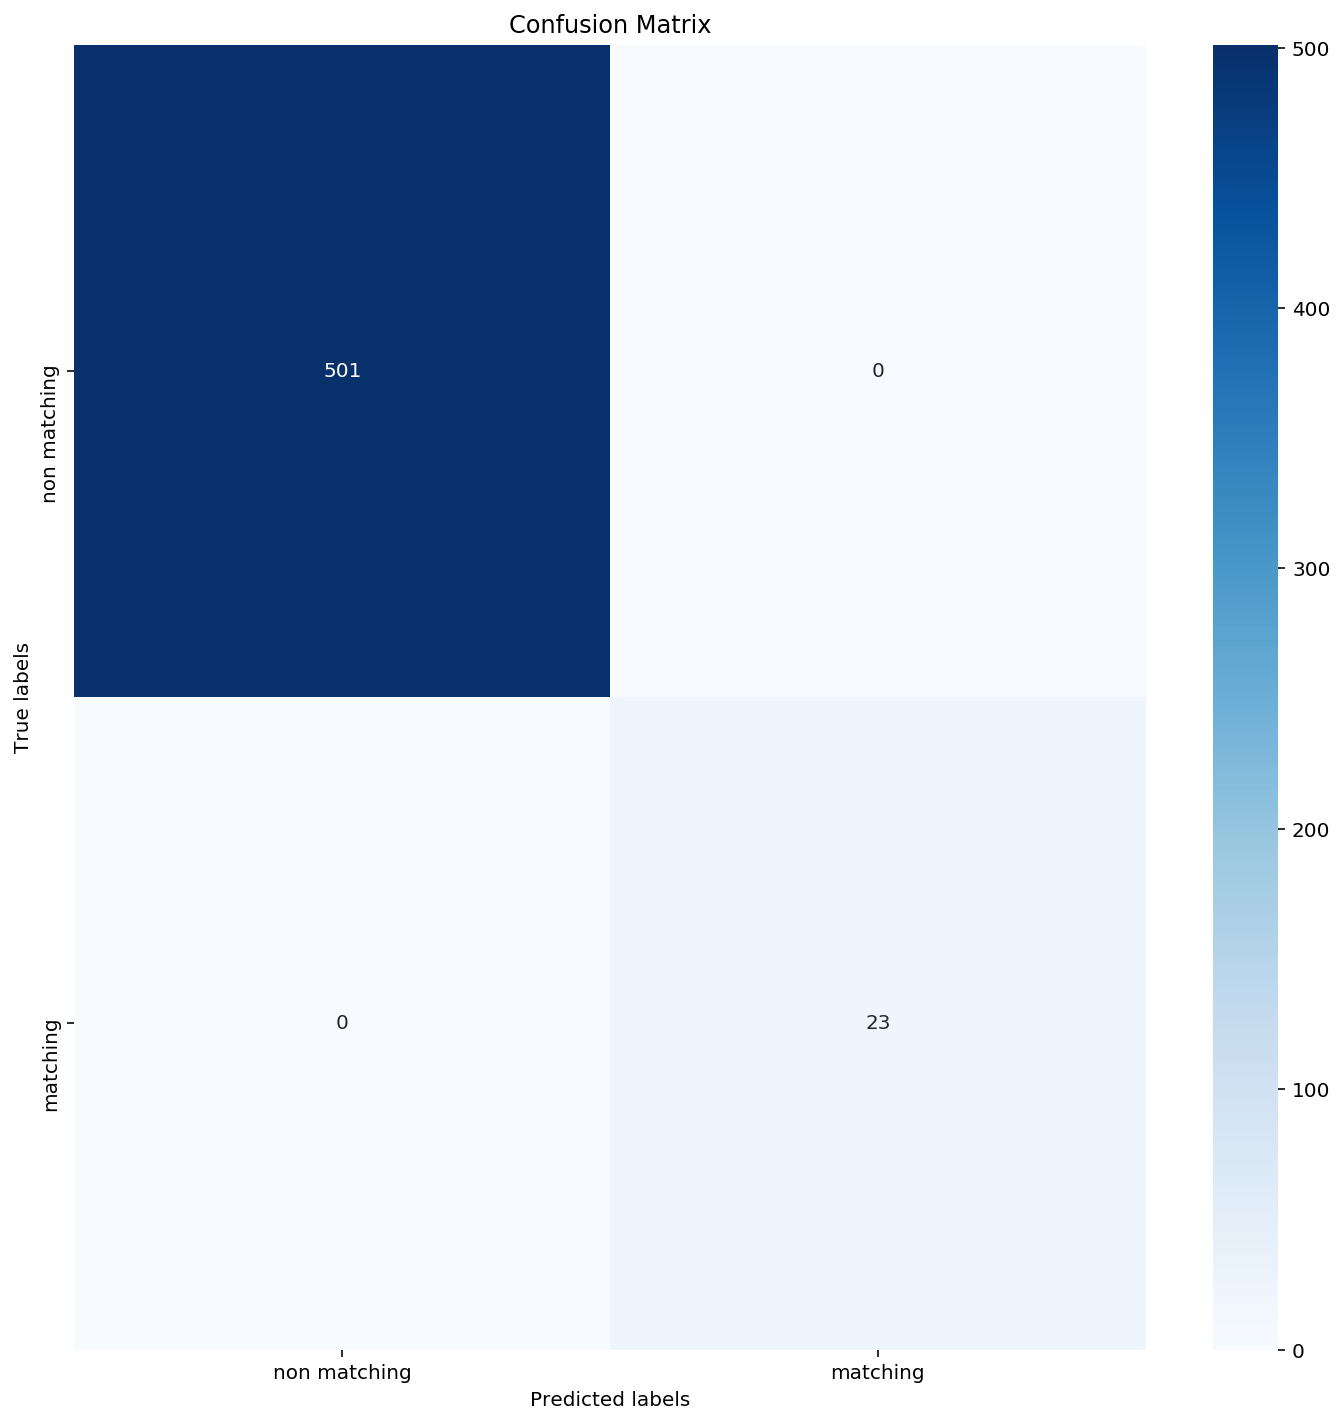

In [24]:
cm = confusion_matrix(testBinaryLabels, predictedBinaryLabels)
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['non matching', 'matching'])
ax.yaxis.set_ticklabels(['non matching', 'matching'])

### Compute metrics

In [28]:
precisionValues, recallValues, fMeasureValues, supportValues = precision_recall_fscore_support(testBinaryLabels, predictedBinaryLabels)

print(row_format.format('Label','Precision', 'Recall', 'F-measure', 'Support'))

for i in range(NUM_LABELS):
    fMeasure = fMeasureValues[i]
    
    if fMeasure is None:
        fMeasure = 0.0
        
    print(row_format.format(i, round(precisionValues[i], 2), round(recallValues[i], 2), round(fMeasureValues[i],2), round(supportValues[i],2)))

          Label      Precision         Recall      F-measure        Support
              0            1.0            1.0            1.0            501
              1            1.0            1.0            1.0             23
